# Examples from extracting ocean currents from a model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cmocean
import xarray as xa
import scipy.ndimage as nd
import cartopy.crs as ccrs
import cartopy.feature as cfeature


import sys,os
testdir = os.path.dirname(os.getcwd() + '/')
srcdir = '..'
sys.path.insert(0, os.path.abspath(os.path.join(testdir, srcdir)))

from ocean_wave_tracing import Wave_tracing

%matplotlib inline


In [2]:
# READ ROMS DATA

fname = 'https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be'
da = xa.open_dataset(fname)

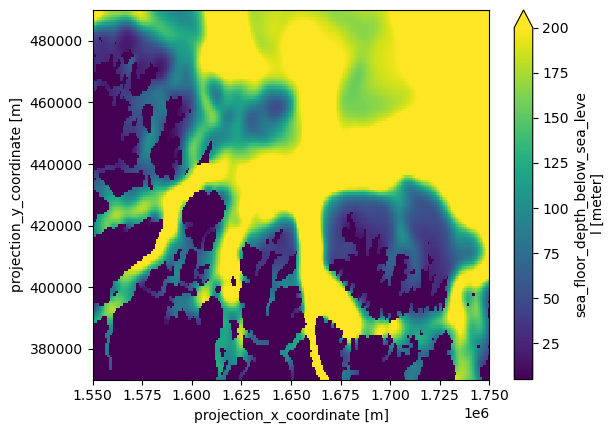

In [3]:
# Subset the dataset
t0, t1 = "2019-01-24T09", "2019-01-24T12"
step = 1
X0, XN = 1.55e6, 1.75e6
Y0, YN = 3.7e5 , 4.9e5
ocn_subset=da.loc[dict(time=slice(np.datetime64(t0),np.datetime64(t1)),
                X=slice(X0,XN,step),Y=slice(Y0,YN))]
                    #X=slice(1.45e6,1.6e6,step),Y=slice(4.3e5,6e5,step))]
ocn_subset.h.plot.pcolormesh(vmax=200)

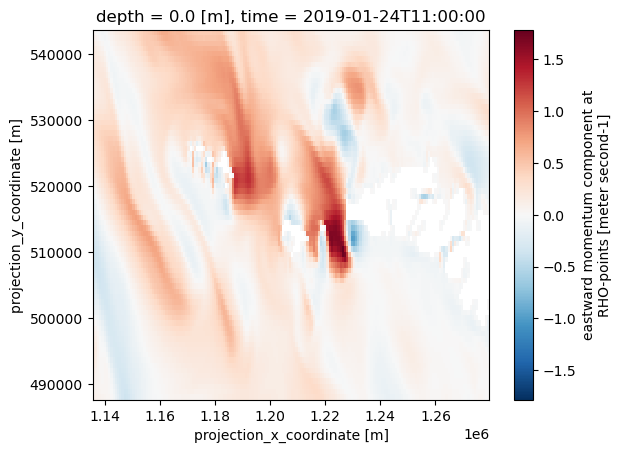

In [4]:
bbox_idx = slice(1420,1600,1) #latitude MOSKEN
bbox_idy = slice(610,680,1) #longitude MOSKEN

ocn_subset_mosken=da.isel(X=bbox_idx,Y=bbox_idy).sel(time=["2019-01-06T01","2019-01-24T11"],
                                                     depth=0,s_rho=0,s_w=0)
                    #X=slice(1.45e6,1.6e6,step),Y=slice(4.3e5,6e5,step))]


ocn_subset_mosken.u_eastward.isel(time=1).plot() #.plot.pcolormesh(vmax=200)

In [5]:
# SET conditions for wave tracing
nb_wave_rays = 50#200#550#nx
T = 4*3600
nt = 1000
wave_period = 10
i_w_side = 'top'
theta0=1.5*np.pi#0


In [6]:
ocn_subset_mosken

<xarray.Dataset> Size: 2MB
Dimensions:                  (X: 180, Y: 70, time: 2)
Coordinates:
  * X                        (X) float64 1kB 1.136e+06 1.137e+06 ... 1.279e+06
  * Y                        (Y) float64 560B 4.88e+05 4.888e+05 ... 5.432e+05
    depth                    float64 8B 0.0
  * time                     (time) datetime64[ns] 16B 2019-01-06T01:00:00 20...
    lat                      (Y, X) float64 101kB ...
    lon                      (Y, X) float64 101kB ...
Data variables: (12/20)
    Cs_r                     float64 8B ...
    Cs_w                     float64 8B ...
    forecast_reference_time  datetime64[ns] 8B ...
    hc                       float64 8B ...
    projection_stere         int32 4B ...
    angle                    (Y, X) float64 101kB ...
    ...                       ...
    ubar                     (time, Y, X) float32 101kB ...
    v                        (time, Y, X) float32 101kB ...
    v_northward              (time, Y, X) float32 101kB ...
    vbar                     (time, Y, X) float32 101kB ...
    w                        (time, Y, X) float32 101kB ...
    zeta                     (time, Y, X) float32 101kB ...
Attributes: (12/59)
    file:                   /home/metno_op/run/norkyst-800m_2017/ocean_his.nc
    type:                   ROMS/TOMS history file
    title:                  NorKyst-800m - ROMS
    var_info:               /home/metno_op/sea/ROMS/metroms_apps/norkyst-800m...
    rst_file:               /home/metno_op/run/norkyst-800m_2017/ocean_rst.nc
    his_file:               /home/metno_op/run/norkyst-800m_2017/ocean_his.nc
    ...                     ...
    publisher_name:         Norwegian Meteorological Institute / Arctic Data ...
    publisher_institution:  Norwegian Meteorological Institute
    publisher_email:        adc-support@met.no
    publisher_url:          https://adc.met.no/
    project:                Ocean and Ice - Research to Operation (HI-R2O)
    license:                https://spdx.org/licenses/CC-BY-4.0.html (CC-BY-4.0)

In [7]:
wt_ocn = Wave_tracing(U=ocn_subset.u_eastward.sel(depth=0).rename({'X':'x','Y':'y'}),
                      V=ocn_subset.v_northward.sel(depth=0).rename({'X':'x','Y':'y'}), 
                      nx=ocn_subset.sizes['X'], ny=ocn_subset.sizes['Y'],
                      nt=nt,T=T,
                      dx=ocn_subset.X.diff(dim='X')[0].values,
                      dy=ocn_subset.Y.diff(dim='Y')[0].values, 
                      nb_wave_rays=nb_wave_rays,
                      domain_X0=ocn_subset.X.min().values, domain_XN=ocn_subset.X.max().values,
                      domain_Y0=ocn_subset.Y.min().values, domain_YN=ocn_subset.Y.max().values,                       
                      temporal_evolution=True, d=ocn_subset.h.values,
                      DEBUG=False)
wt_ocn.set_initial_condition(wave_period=wave_period, theta0=theta0,incoming_wave_side=i_w_side)
wt_ocn.solve()

In [8]:
wt_zero = Wave_tracing(U=ocn_subset.u_eastward.sel(depth=0).rename({'X':'x','Y':'y'})*0, 
                       V=ocn_subset.v_northward.sel(depth=0).rename({'X':'x','Y':'y'})*0, 
                      nx=ocn_subset.sizes['X'], ny=ocn_subset.sizes['Y'],
                      nt=nt,T=T,
                      dx=ocn_subset.X.diff(dim='X')[0].values,
                      dy=ocn_subset.Y.diff(dim='Y')[0].values, 
                      nb_wave_rays=nb_wave_rays,
                      domain_X0=ocn_subset.X.min().values, domain_XN=ocn_subset.X.max().values,
                      domain_Y0=ocn_subset.Y.min().values, domain_YN=ocn_subset.Y.max().values,                      
                      temporal_evolution=False, d=ocn_subset.h.values,
                      DEBUG=False)
wt_zero.set_initial_condition(wave_period=wave_period, theta0=theta0, incoming_wave_side=i_w_side)
wt_zero.solve()

In [9]:
wt_mosk_OT = Wave_tracing(U=ocn_subset_mosken.u_eastward.isel(time=0).rename({'X':'x','Y':'y'}), 
                          V=ocn_subset_mosken.v_northward.isel(time=0).rename({'X':'x','Y':'y'}), 
                          nx=ocn_subset_mosken.sizes['X'], ny=ocn_subset_mosken.sizes['Y'],
                          nt=400,T=1.2*3600,
                          dx=ocn_subset.X.diff(dim='X')[0].values,
                          dy=ocn_subset.Y.diff(dim='Y')[0].values, 
                          nb_wave_rays=nb_wave_rays,
                          domain_X0=ocn_subset_mosken.X.min().values, domain_XN=ocn_subset_mosken.X.max().values,
                          domain_Y0=ocn_subset_mosken.Y.min().values, domain_YN=ocn_subset_mosken.Y.max().values,                      
                          temporal_evolution=False, d=ocn_subset_mosken.h.values,
                      DEBUG=False)

ipx = np.linspace(1.21e6,1.24e6,nb_wave_rays)
ipy = np.ones(nb_wave_rays)*5.35e5

wt_mosk_OT.set_initial_condition(wave_period=13, theta0=-0.57*np.pi, ipx=ipx,ipy=ipy)
wt_mosk_OT.solve()

In [10]:
wt_mosk_IT = Wave_tracing(U=ocn_subset_mosken.u_eastward.isel(time=1).rename({'X':'x','Y':'y'}), 
                          V=ocn_subset_mosken.v_northward.isel(time=1).rename({'X':'x','Y':'y'}), 
                          nx=ocn_subset_mosken.sizes['X'], ny=ocn_subset_mosken.sizes['Y'],
                          nt=400,T=1.0*3600,
                          dx=ocn_subset.X.diff(dim='X')[0].values,
                          dy=ocn_subset.Y.diff(dim='Y')[0].values, 
                          nb_wave_rays=nb_wave_rays,
                          domain_X0=ocn_subset_mosken.X.min().values, domain_XN=ocn_subset_mosken.X.max().values,
                          domain_Y0=ocn_subset_mosken.Y.min().values, domain_YN=ocn_subset_mosken.Y.max().values,                      
                          temporal_evolution=False, d=ocn_subset_mosken.h.values,
                      DEBUG=False)


central_angle = -0.50*np.pi+np.pi
theta0_IT = np.linspace(central_angle-0.6,central_angle+0.6,nb_wave_rays)
ipx = np.ones(nb_wave_rays)*1.223e6
ipy = np.ones(nb_wave_rays)*5.01e5

wt_mosk_IT.set_initial_condition(wave_period=7, theta0=theta0_IT, ipx=ipx,ipy=ipy)
wt_mosk_IT.solve()

## Transform to latlon and make xarray DataSet

In [11]:
proj_str = ocn_subset.projection_stere.proj4
ds_ocn = wt_ocn.to_ds(proj4=proj_str)
ds_zero = wt_zero.to_ds(proj4=proj_str)
ds_mosk_OT = wt_mosk_OT.to_ds(proj4=proj_str)
ds_mosk_IT = wt_mosk_IT.to_ds(proj4=proj_str)

In [12]:
speed_OT = np.sqrt(wt_mosk_OT.U[0,:,:]**2 + wt_mosk_OT.V[0,:,:]**2)
speed_IT = np.sqrt(wt_mosk_IT.U[0,:,:]**2 + wt_mosk_IT.V[0,:,:]**2)

In [13]:
fs = 18 #font size
crs_kws = dict(projection=ccrs.NorthPolarStereo(), facecolor="0.90")
data_crs = ccrs.PlateCarree()
geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))

#lscale='full'
lscale='intermediate'
f = cfeature.GSHHSFeature(scale=lscale, levels=[1],
        facecolor=cfeature.COLORS['land'])

# SET plot extent
lonmin, lonmax, latmin, latmax = -10,25,50,80#12.1+0.4, 13.2, 67.7-0.1, 68
plot_extent = [lonmin, lonmax, latmin, latmax ]

In [14]:
# Extrac subset model domain
subset_lon_extent = np.concatenate((ocn_subset.lon[:,-1], ocn_subset.lon[:,0], ocn_subset.lon[0,:], ocn_subset.lon[-1,:]))
subset_lat_extent = np.concatenate((ocn_subset.lat[:,-1], ocn_subset.lat[:,0], ocn_subset.lat[0,:], ocn_subset.lat[-1,:]))

subset_lon_extent_mosk = np.concatenate((ocn_subset_mosken.lon[:,-1], ocn_subset_mosken.lon[:,0], ocn_subset_mosken.lon[0,:], ocn_subset_mosken.lon[-1,:]))
subset_lat_extent_mosk = np.concatenate((ocn_subset_mosken.lat[:,-1], ocn_subset_mosken.lat[:,0], ocn_subset_mosken.lat[0,:], ocn_subset_mosken.lat[-1,:]))

## Plot

C:\Users\tpvan\miniforge3\envs\wave_tracing\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
C:\Users\tpvan\miniforge3\envs\wave_tracing\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
C:\Users\tpvan\miniforge3\envs\wave_tracing\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
C:\Users\tpvan\miniforge3\envs\wave_tracing\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
C:\Users\tpvan\miniforge3\envs\wave_tracing\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
C:\Users\tpvan\minif

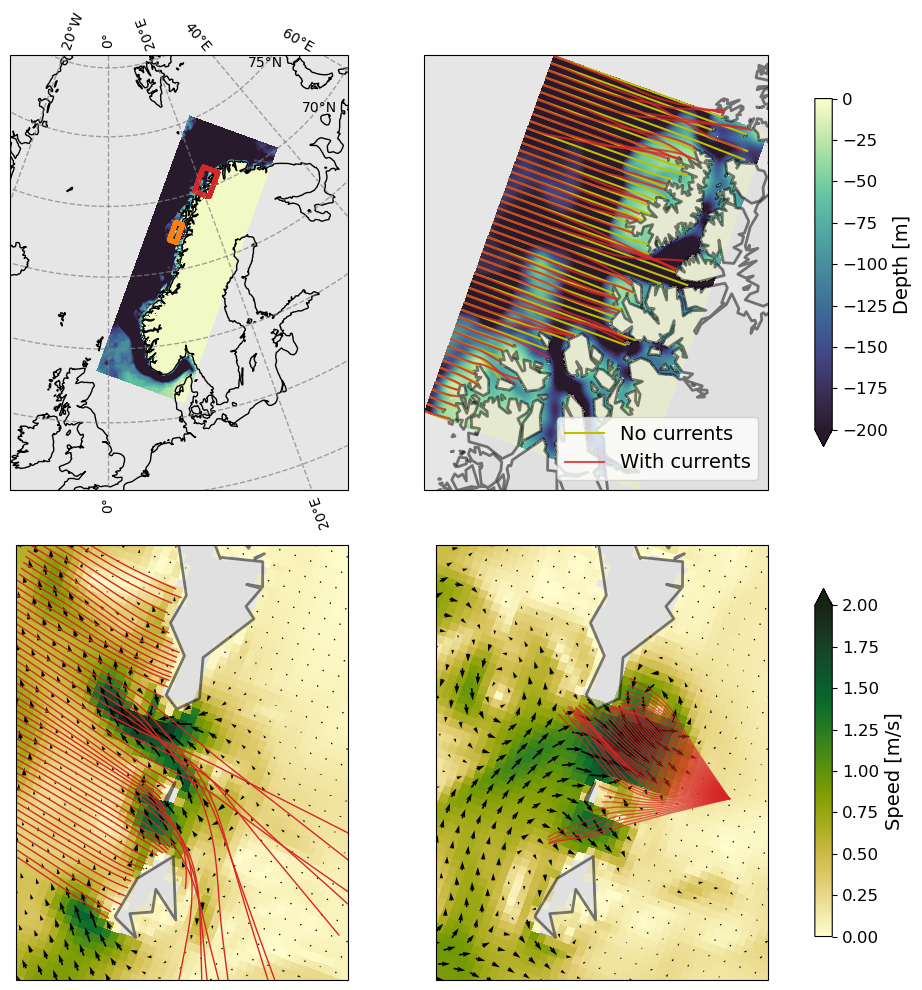

In [15]:
fs=14
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,10),frameon=False,subplot_kw=crs_kws)
 

pc=ax[0,0].pcolormesh(da.lon,da.lat,-da.h,shading='auto',cmap=cmocean.cm.deep_r,
                         vmin=-200,vmax=0, transform=data_crs)
pc1=ax[0,1].pcolormesh(ocn_subset.lon,ocn_subset.lat,-wt_ocn.d,shading='auto',cmap=cmocean.cm.deep_r,
                         vmin=-200,vmax=0, transform=data_crs)


ax[0,0].plot(subset_lon_extent, subset_lat_extent,marker='o',ms=2,linestyle='None',c='tab:red',
           label='Subset domain',transform=data_crs)

ax[0,0].plot(subset_lon_extent_mosk, subset_lat_extent_mosk,marker='o',ms=2,linestyle='None',c='tab:orange',
           label='Subset domain',transform=data_crs)

step=1
for i in range(0,wt_zero.nb_wave_rays,step):
    if i ==0:        
        ax[0,1].plot(ds_zero.ray_lon[i,:],ds_zero.ray_lat[i,:],c='y',lw=1.5, alpha=1,label='No currents',transform=data_crs)
    else:
        ax[0,1].plot(ds_zero.ray_lon[i,:],ds_zero.ray_lat[i,:],c='y',lw=1.5,alpha=1,transform=data_crs)

for i in range(0,wt_ocn.nb_wave_rays,step):
    if i == 0:
        ax[0,1].plot(ds_ocn.ray_lon[i,:],ds_ocn.ray_lat[i,:],c='tab:red',lw=1.5,alpha=0.8,label='With currents',transform=data_crs)        
    else:
        ax[0,1].plot(ds_ocn.ray_lon[i,:],ds_ocn.ray_lat[i,:],c='tab:red',lw=1.5,alpha=0.8,transform=data_crs)


ax[0,1].legend(fontsize=fs,loc='lower right')
ax[0,0].coastlines()
#ax[1].coastlines()
ax[0,0].set_extent([-10,25,50,80],geodetic)

#ax.set_extent(plot_extent, geodetic)
ax[0,1].add_geometries(
        f.intersecting_geometries([lonmin, lonmax, latmin-.1, latmax]),
        ccrs.PlateCarree(),
        facecolor=cfeature.COLORS['land_alt1'],
        edgecolor='black',alpha=0.5,linewidth=2)


gl = ax[0,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1., color='gray', alpha=0.7, linestyle='--')

ax[0,0].tick_params(labelsize=fs)


pc2=ax[1,0].pcolormesh(ocn_subset_mosken.lon, ocn_subset_mosken.lat, speed_OT[:,:],
                           cmap=cmocean.cm.speed, vmax=2, transform=data_crs)

jump2=2
ax[1,0].quiver(ocn_subset_mosken.lon.data[::jump2,::jump2], 
            ocn_subset_mosken.lat.data[::jump2,::jump2], 
            ocn_subset_mosken.u_eastward.isel(time=0).data[::jump2,::jump2], 
            ocn_subset_mosken.v_northward.isel(time=0).data[::jump2,::jump2],
            width=0.005, scale=25, color='k',pivot='mid', transform=data_crs, 
            target_extent=plot_extent,alpha=1)



pc3=ax[1,1].pcolormesh(ocn_subset_mosken.lon, ocn_subset_mosken.lat, speed_IT[:,:],
                           cmap=cmocean.cm.speed, vmax=2, transform=data_crs)
ax[1,1].quiver(ocn_subset_mosken.lon.data[::jump2,::jump2], 
            ocn_subset_mosken.lat.data[::jump2,::jump2], 
            ocn_subset_mosken.u_eastward.isel(time=1).data[::jump2,::jump2], 
            ocn_subset_mosken.v_northward.isel(time=1).data[::jump2,::jump2],
            width=0.005, scale=25, color='k',pivot='mid', transform=data_crs, 
            target_extent=plot_extent,alpha=1)

for i in range(0,wt_mosk_IT.nb_wave_rays,1):
    ax[1,0].plot(ds_mosk_OT.ray_lon[i,:],ds_mosk_OT.ray_lat[i,:],'-',c='tab:red',transform=ccrs.PlateCarree(),alpha=1,lw=1)
    ax[1,1].plot(ds_mosk_IT.ray_lon[i,:],ds_mosk_IT.ray_lat[i,:],'-',c='tab:red',
                 alpha=0.7,transform=ccrs.PlateCarree(),lw=1)



for aax in [ax[1,0],ax[1,1]]:

    aax.set_extent([12.5, 13.1, 67.6, 67.95], geodetic)
    aax.add_geometries(
            f.intersecting_geometries(plot_extent),
            ccrs.PlateCarree(),
            facecolor=cfeature.COLORS['land_alt1'],
            edgecolor='black',alpha=0.5,linewidth=2)


fig.tight_layout()

cb = fig.colorbar(pc,ax=[ax[0,0],ax[0,1]],shrink=0.8,pad=0.04,extend='min',orientation='vertical')
cb.set_label('Depth [m]',fontsize=fs)

cb2 = fig.colorbar(pc2,ax=[ax[1,0],ax[1,1]],shrink=0.8,pad=0.04,extend='max',orientation='vertical')
cb2.set_label('Speed [m/s]',fontsize=fs)

for ccb in [cb,cb2]:
    ccb.ax.tick_params(labelsize=fs-2) 

#fig.savefig(fname='ocean_model_example.png', dpi=130,transparent=False)


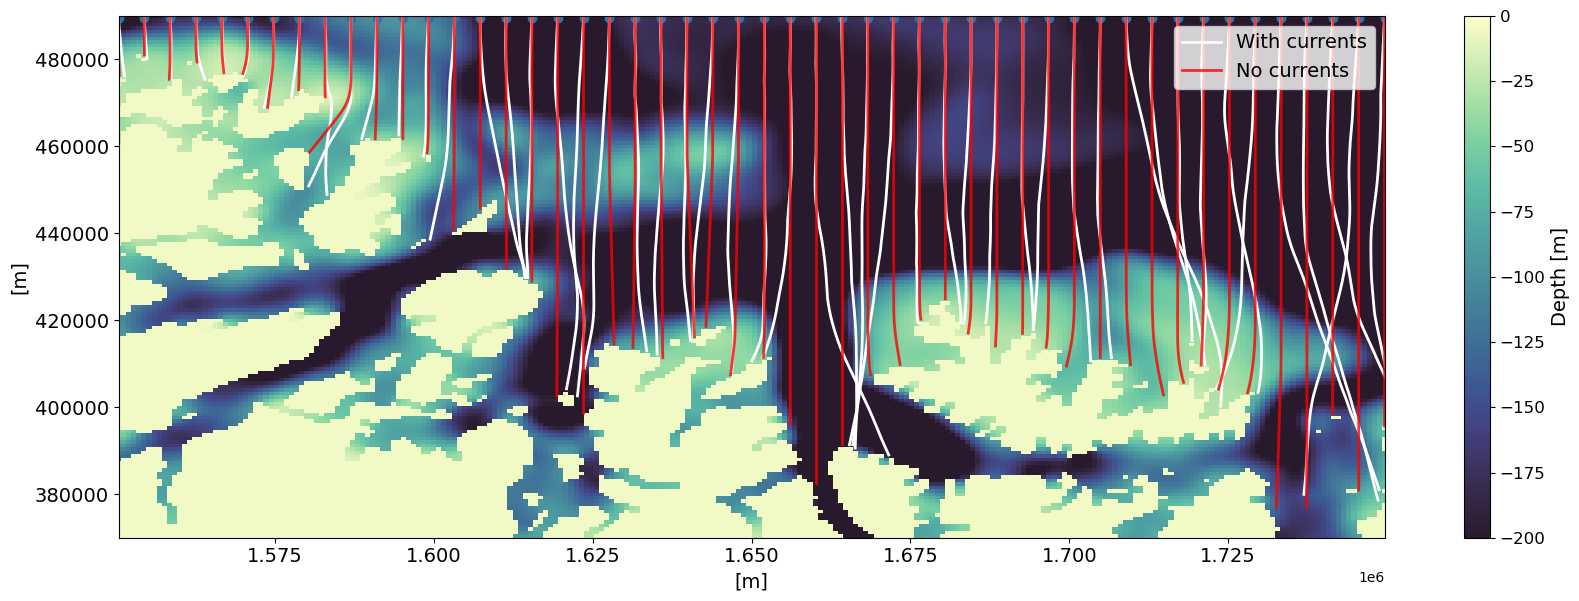

In [16]:
fs=14
fig,ax = plt.subplots(figsize=(17,6))
 
pc=ax.pcolormesh(wt_ocn.x,wt_ocn.y,-wt_ocn.d,shading='auto',cmap=cmocean.cm.deep_r,
                         vmin=-200,vmax=0)

    

ax.plot(wt_ocn.ray_x[:,0],wt_ocn.ray_y[:,0],'o')
step=1
for i in range(0,wt_ocn.nb_wave_rays,step):
    if i == 0:
        ax.plot(ds_ocn.ray_x[i,:],ds_ocn.ray_y[i,:],'-w',lw=2,alpha=1,label='With currents')        
    else:
        ax.plot(ds_ocn.ray_x[i,:],ds_ocn.ray_y[i,:],'-w',lw=2,alpha=1)
    
for i in range(0,wt_zero.nb_wave_rays,step):
    if i ==0:        
        ax.plot(ds_zero.ray_x[i,:],ds_zero.ray_y[i,:],'r',lw=2, alpha=0.8,label='No currents')
    else:
        ax.plot(ds_zero.ray_x[i,:],ds_zero.ray_y[i,:],c='r',lw=2,alpha=.8)

ax.set_xlim([wt_ocn.domain_X0,wt_ocn.domain_XN])

ax.set_xlabel('[m]',fontsize=fs)
ax.set_ylabel('[m]',fontsize=fs)

ax.legend(fontsize=fs,loc='upper right')

fig.tight_layout()

cb = fig.colorbar(pc)
cb.set_label('Depth [m]',fontsize=fs)

cb.ax.tick_params(labelsize=fs-2) 

ax.tick_params(labelsize=fs)